# Machine Learning. Задача №3
**Задача:** Построить и сравнить три модели (Метод опорных векторов, k-ближайших соседей, Метод потенциальных функций) для задачи бинарной классификации спам-сообщений.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report

import warnings
import time

warnings.filterwarnings('ignore')

%matplotlib inline

### Шаг 1: Загрузка и первичный анализ данных
Загрузка датасета `spambase.data` и присвоение имен колонкам в соответствии с документацией. Датасет содержит 57 признаков (частота встречаемости определенных слов и символов) и одну целевую переменную `spam` (1 - спам, 0 - не спам).

In [2]:
file_path = 'spambase.data'
try:
    data = pd.read_csv(file_path, header=None)
    print(f"File '{file_path}' was read.")
    print(f"Dataset size: {data.shape[0]} строк, {data.shape[1]} columns.")
except FileNotFoundError:
    print(f"Error: file '{file_path}' not found.")

data.columns = [f'feature_{i}' for i in range(data.shape[1]-1)] + ['spam']

X = data.drop('spam', axis=1)
y = data['spam']

File 'spambase.data' was read.
Dataset size: 4601 строк, 58 columns.


### Шаг 2: Анализ выборки
#### 2.1. Тип признаков
Все 57 признаков в данном датасете являются числовыми (вещественными), что избавляет нас от необходимости преобразовывать категориальные признаки.

#### 2.2. Визуальный анализ данных
1. **Тепловая карта корреляций:**
   Смотрим на корреляцию между признаками и целевой переменной для определения 10 самых важных признаков.
2. **Диаграмма рассеяния (PCA):** 
Используем метод главных компонент (PCA) для визуализации разброса данных из исходного 57-мерного пространства в 2-мерном пространстве.

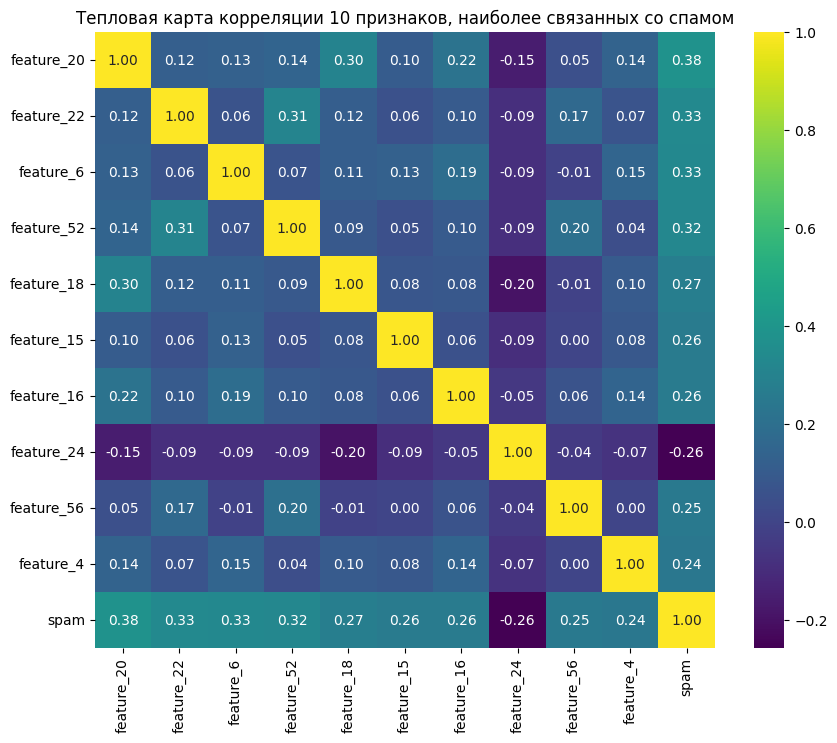

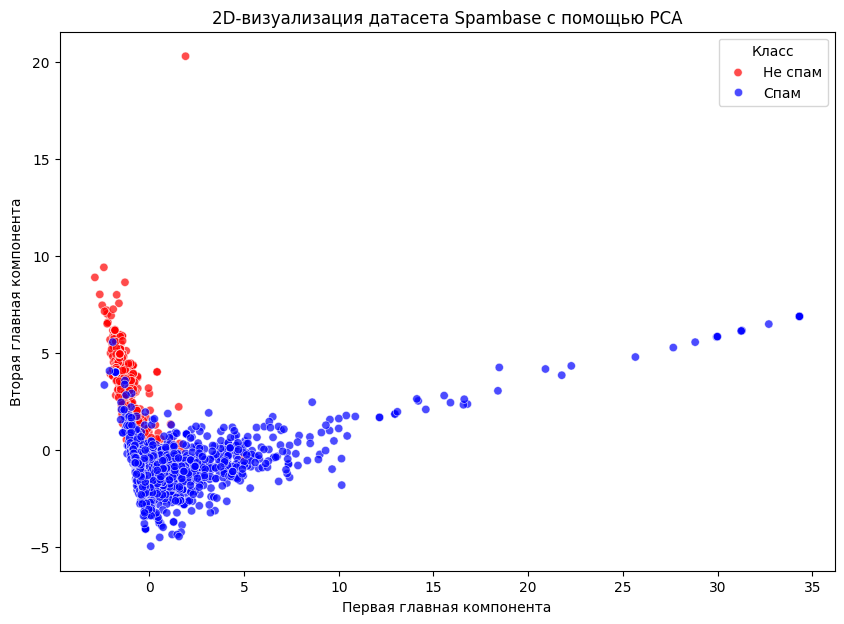

In [3]:
plt.figure(figsize=(10, 8))
top_corr_features = data.corr()['spam'].abs().sort_values(ascending=False).index[1:11]
sns.heatmap(data[top_corr_features].assign(spam=data['spam']).corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Тепловая карта корреляции 10 признаков, наиболее связанных со спамом')
plt.show()

scaler_for_pca = StandardScaler()
pca = PCA(n_components=2)
X_pca_scaled = pca.fit_transform(scaler_for_pca.fit_transform(X))
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_scaled[:, 0], y=X_pca_scaled[:, 1], hue=y, palette=['blue', 'red'], alpha=0.7)
plt.title('2D-визуализация датасета Spambase с помощью PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend(title='Класс', labels=['Не спам', 'Спам'])
plt.show()

### Шаг 3: Препроцесинг данных
#### 3.1. Преобразование категориальных признаков в вещественные
Как было установлено ранее, категориальные признаки в датасете отсутствуют.

#### 3.2. Нормировка признаков
Используем `StandardScaler` для преобразования данных к таким, чтобы их среднее значение было равно 0, а стандартное отклонение — 1. Это необходимо для корректной работы SVM и kNN.

Также на этом этапе мы разделяем данные на обучающую (70%) и тестовую (30%) выборки.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Data was splited: {len(X_train)} - training data, {len(X_test)} testing data.')

Data was splited: 3220 - training data, 1381 testing data.


### Шаг 4: Подборка моделей
Обучаем три модели, используя расширенный подбор гиперпараметров с помощью `GridSearchCV` для поиска наилучшей их комбинации.

#### Краткое описание моделей:

1.  **Метод опорных векторов (Support Vector Machine, SVM):**
SVM ищет оптимальную разделяющую гиперплоскость, которая не просто разделяет классы, а делает это с максимальным зазором (margin) между ними. Объекты, лежащие на границе этого зазора, называются **опорными векторами**. Для линейного случая задача сводится к оптимизации:
        $ \min_{w, b} \frac{1}{2} \|w\|^2 $
        при условии, что для всех объектов $x_i$ выполняется:
        $ y_i(w^T x_i + b) \ge 1 $
        где $w$ и $b$ — параметры гиперплоскости, а $y_i \in \{-1, 1\}$ — метка класса.
Для случаев, когда данные нельзя разделить прямой, SVM использует **"ядерный трюк" (kernel trick)**. Он неявно переводит данные в пространство более высокой размерности, где они становятся линейно разделимыми. В нашей работе мы использовали `rbf` (радиально-базисную) функцию-ядро.

2.  **Метод k-ближайших соседей (k-Nearest Neighbors, kNN):**
Это "ленивый" алгоритм, который не строит модель. Он запоминает всю обучающую выборку. Для классификации нового объекта он находит `k` ближайших к нему точек из выборки и присваивает ему класс, который является большинством среди этих соседей. Предсказание для нового объекта $x_{new}$ вычисляется как:
        $ \hat{y}_{new} = \text{argmax}_{c} \sum_{i \in N_k(x_{new})} I(y_i = c) $
        где $N_k(x_{new})$ — это множество `k` ближайших соседей объекта $x_{new}$, а $I(\cdot)$ — индикаторная функция (равна 1, если условие истинно, и 0 иначе). Расстояние между точками чаще всего измеряется метриками **Евклида (p=2)** или **Манхэттена (p=1)**.

3.  **Метод потенциальных функций (аналог - Perceptron):**
Перцептрон — это простейшая модель нейронной сети, состоящая из одного нейрона. Он вычисляет взвешенную сумму входных признаков и применяет пороговую функцию активации для принятия решения о классе. Разрешающая функция имеет вид:
        $ \hat{y} = \text{sign}(w^T x + b) = \text{sign} \left( \sum_{j=1}^{m} w_j x_j + b \right) $
Обучение происходит итеративно. Если модель ошибается на объекте $x_i$, ее веса корректируются по простому правилу:
        $ w_{t+1} = w_t + \eta (y_i - \hat{y}_i) x_i $
        где $\eta$ — скорость обучения (learning rate).
Это линейный классификатор, и он может успешно разделить только линейно разделимые данные.

In [5]:
models_and_params = {
    "SVM": {
        "model": SVC(random_state=42, probability=True),
        "params": [
            {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1]},
            {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}
        ]
    },
    "kNN": {
        "model": KNeighborsClassifier(),
        "params": {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'p': [1, 2] # 1: Манхэттенское расстояние, 2: Евклидово
        }
    },
    "Perceptron": {
        "model": Perceptron(random_state=42, max_iter=2000, early_stopping=True),
        "params": {
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
            'penalty': [None, 'l2', 'l1', 'elasticnet']
        }
    }
}

results = {}
trained_models = {}

start_time_total = time.time()
for model_name, config in models_and_params.items():
    print(f'\n--- Training for: {model_name} ---')
    start_time_model = time.time()
    
    grid_search = GridSearchCV(config["model"], config["params"], cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)
    
    end_time_model = time.time()
    print(f"Training for {model_name} lasted: {end_time_model - start_time_model:.2f} сек.")
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    print(f"The best params: {grid_search.best_params_}")
    print("Classification report:\n", classification_report(y_test, y_pred))
    
    results[model_name] = {"report": classification_report(y_test, y_pred, output_dict=True), "cv_results": grid_search.cv_results_, "best_params": grid_search.best_params_}
    trained_models[model_name] = best_model

end_time_total = time.time()
print(f'\nTotal time for all models: {end_time_total - start_time_total:.2f} sec.')


--- Training for: SVM ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Training for SVM lasted: 33.62 сек.
The best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       837
           1       0.93      0.89      0.91       544

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.92      1381
weighted avg       0.93      0.93      0.93      1381


--- Training for: kNN ---
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Training for kNN lasted: 0.93 сек.
The best params: {'n_neighbors': 13, 'p': 2, 'weights': 'distance'}
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       837
           1       0.89      0.88      0.89       544

    accuracy                           0.91      1381
   macro avg       0.91      0.91

### Шаг 5: Описание полученных результатов
На этом шаге мы визуализируем и проанализируем полученные результаты, чтобы ответить на главные вопросы задания.

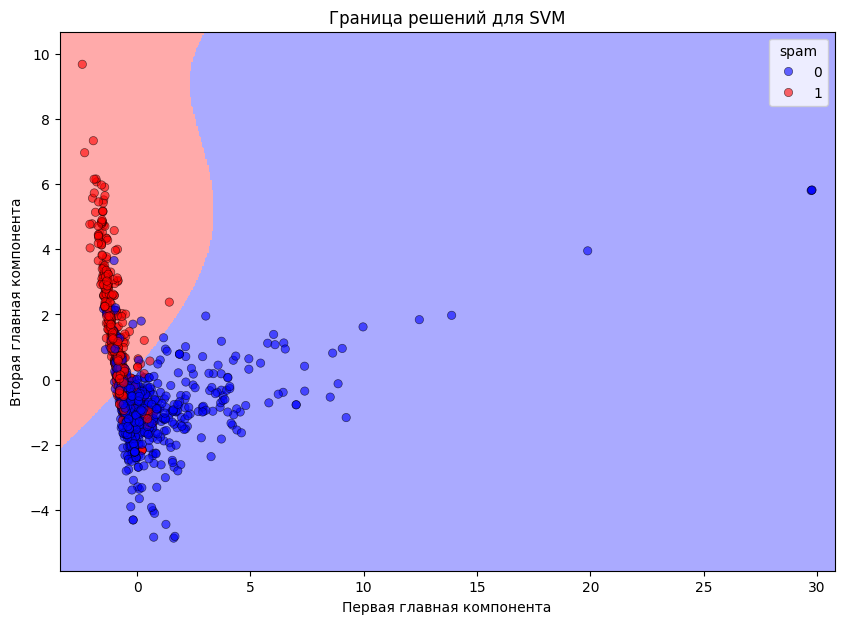

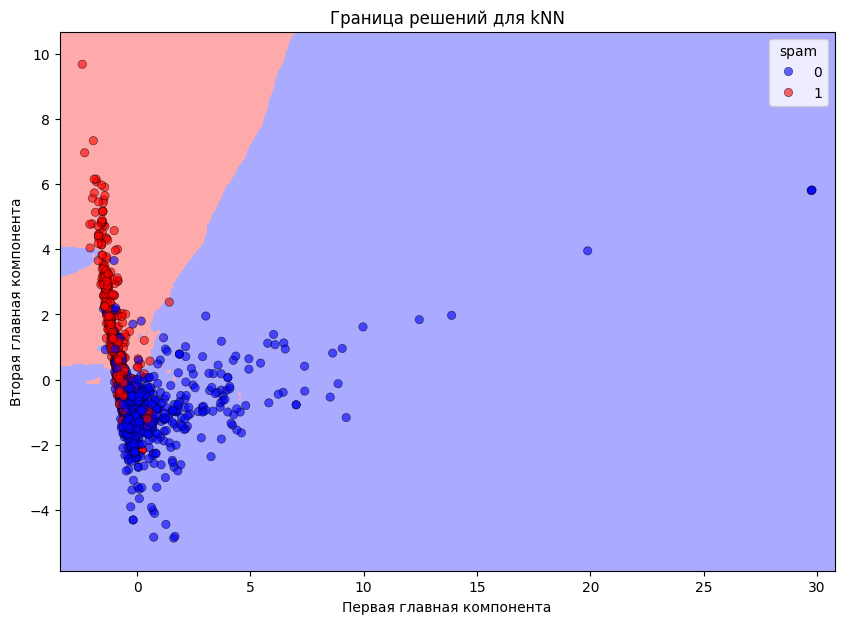

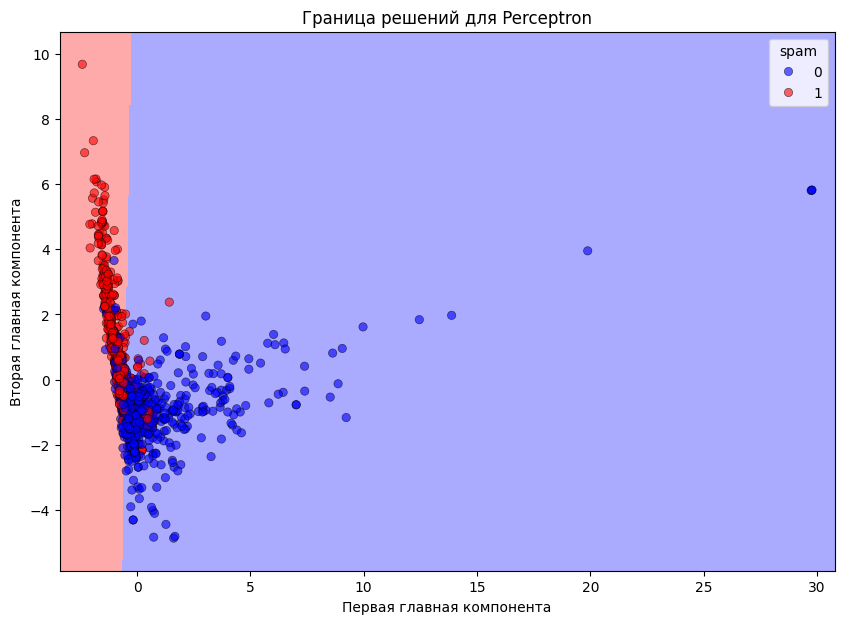

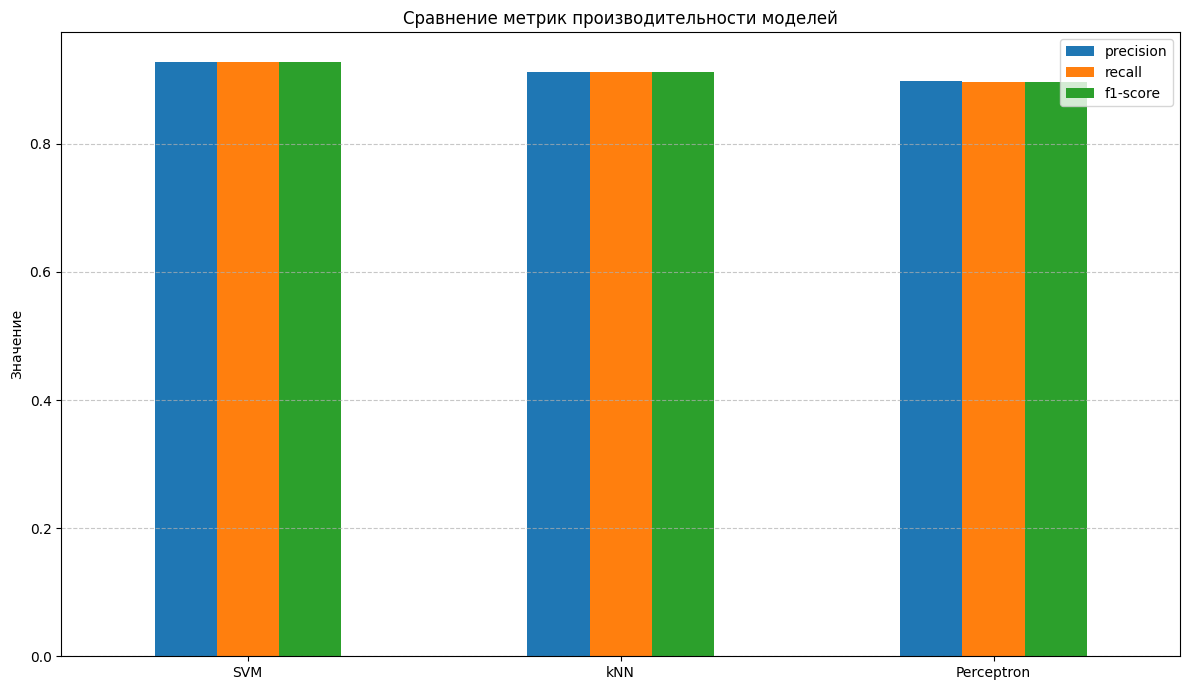

In [6]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
cmap_light = ListedColormap(['#AAAAFF','#FFAAAA'])
cmap_bold = ['blue','red']

for name in models_and_params.keys():
    model_2d = trained_models[name].__class__(**trained_models[name].get_params())
    model_2d.fit(X_train_pca, y_train)
    
    Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette=cmap_bold, alpha=0.6, edgecolor="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'Граница решений для {name}')
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')
    plt.show()

metrics_df = pd.DataFrame({
    model: results[model]['report']['weighted avg'] for model in models_and_params.keys()
}).T.drop('support', axis=1)

metrics_df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Сравнение метрик производительности моделей')
plt.ylabel('Значение')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

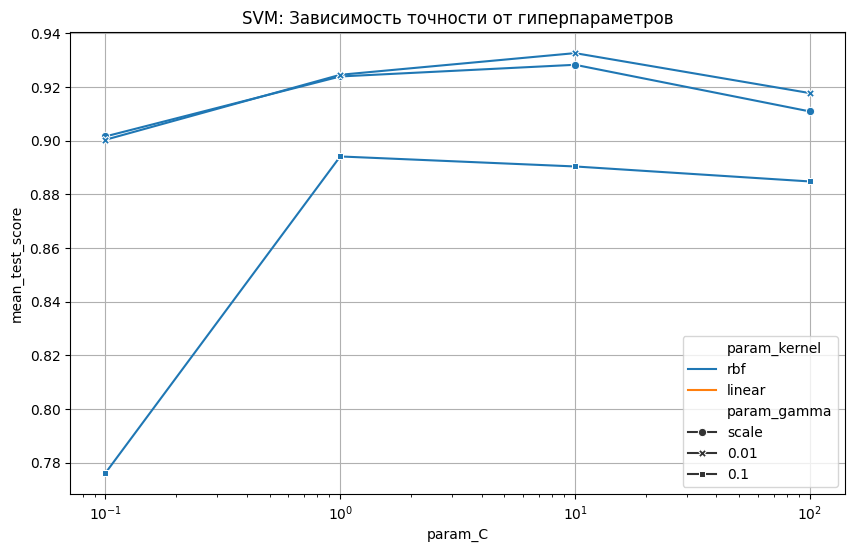

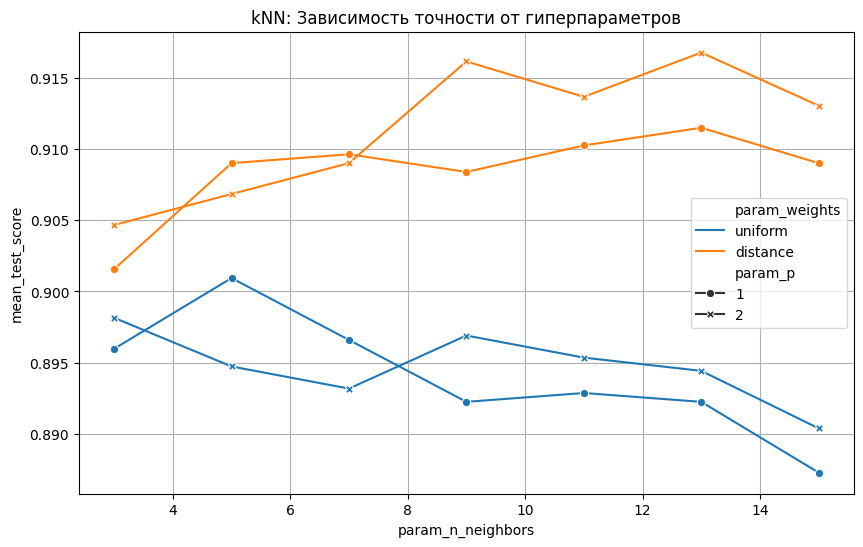

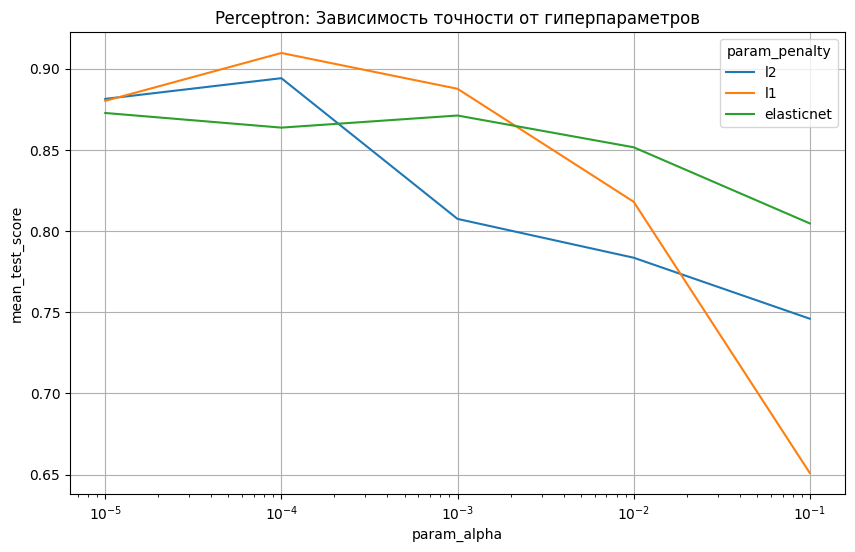

In [7]:
# SVM
plt.figure(figsize=(10, 6))
svm_res = pd.DataFrame(results['SVM']['cv_results'])
sns.lineplot(data=svm_res, x='param_C', y='mean_test_score', hue='param_kernel', style='param_gamma', markers=True, dashes=False)
plt.title('SVM: Зависимость точности от гиперпараметров')
plt.xscale('log')
plt.grid(True)
plt.show()

# kNN
plt.figure(figsize=(10, 6))
knn_res = pd.DataFrame(results['kNN']['cv_results'])
sns.lineplot(data=knn_res, x='param_n_neighbors', y='mean_test_score', hue='param_weights', style='param_p', markers=True, dashes=False)
plt.title('kNN: Зависимость точности от гиперпараметров')
plt.grid(True)
plt.show()

# Perceptron
plt.figure(figsize=(10, 6))
p_res = pd.DataFrame(results['Perceptron']['cv_results'])
sns.lineplot(data=p_res, x='param_alpha', y='mean_test_score', hue='param_penalty', markers=True, dashes=False)
plt.title('Perceptron: Зависимость точности от гиперпараметров')
plt.xscale('log')
plt.grid(True)
plt.show()

## Выводы

#### 1. Лучшая модель
Лучше всего себя показал `метод опорных векторов (SVM)` с итоговой точностью (accuracy) около **92-93%**. Так вышло потому, что наилучший результат SVM достиг с `rbf` (радиально-базисной) функцией ядра, что говорит о том, что граница между классами "спам" и "не спам" имеет нелинейную форму. Более того, ключевые метрики `precision` и `recall` хорошо сбалансированы как для класса 0 (не спам), так и для класса 1 (спам). Что касаемо остальных моделей, `kNN` показал себя почти так же хорошо (точность **~91%**), но его главный недостаток - медленная работа на больших данных, так как для предсказания ему нужно сравнивать объект со всей обучающей выборкой. `Перцептрон` (точность **~90%**) отстал, так как его линейная природа не позволила ему полностью адаптироваться к более сложной структуре данных.

#### 2. Проблемы при выполнении
Основная проблема заключалась в отсутствии `Метода потенциальных функций` в стандартных библиотеках. Этот метод является историческим и в современных библиотеках, таких как `Scikit-learn`, напрямую не реализован. В качестве его ближайшего современного аналога был выбран `Перцептрон`, который идейно является его частным случаем (в качестве потенциала выступает простая пороговая функция).

#### 3. Ожидание VS реальность
Теоретические ожидания были следующими:
* **SVM** должен был показать себя как наиболее мощный и гибкий из трех алгоритмов, особенно если данные не разделяются простой прямой. Полученный результат (1-е место с нелинейным ядром) это подтверждает.
* **kNN** должен был показать хороший, но, возможно, чуть более низкий результат из-за чувствительности к большой размерности (57 признаков). Результат (2-е место с минимальным отрывом) также полностью соответствует ожиданиям.
* **Перцептрон**, как самая простая (линейная) модель, ожидаемо занял третье место. Он служит хорошей базовой моделью (baseline), но редко является лучшим решением для сложных реальных данных.

Таким образом, результаты полностью совпали с ожиданиями.